In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from PIL import Image, ImageOps
from pathlib import Path
from torchvision.transforms import v2
import sys

sys.path.append('..')

from PAC.data import Downsample


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


In [2]:
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(0)
orig_img = Image.open(Path('../data/train_b/Monet') / 'Terrace_of_Saint-Adresse.jpg')

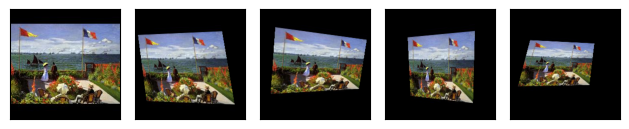

In [3]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot([orig_img] + perspective_imgs)

In [4]:
def resize_image(image_path, new_size=(224,224), resize=None):
    image = Image.open(image_path)
    image.thumbnail(new_size)
    delta_w = new_size[0] - image.size[0]
    delta_h = new_size[1] - image.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    image = ImageOps.expand(image, padding)
    if resize:
        image = image.resize(resize)
    return image

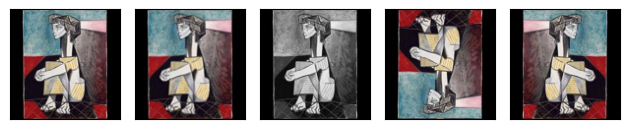

In [5]:
image_path = Path('../data/train_b/Picasso') / 'Donna_dalle_mani_intrecciate.jpg'
orig_img_2 = Image.open(image_path)
downsample_transformer = Downsample((224, 224))
downsampled_img = [downsample_transformer(orig_img_2) for _ in range(1)][0]
greyscale_transfromer = v2.Grayscale(3)
greyscale_image = [greyscale_transfromer(orig_img_2) for _ in range(1)][0]
vertical_flip_image = v2.functional.vertical_flip(orig_img_2)
horizontal_flip_image = v2.functional.horizontal_flip(orig_img_2)
plot([orig_img_2] + [downsampled_img] + [greyscale_image] + [vertical_flip_image] + [horizontal_flip_image])